In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install skforecast

## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent. However, we want to predict all variables therefore therefore, we are going build a model that can handle parallel multiseries data

> Parallel multiseries forcasting can be:
 * ***Dependent*** multi-series => using *ForecasterAutoregMultiSeries* and *ForecasterAutoregMultiSeriesCustom* classes
 * ***Independent*** multiseries => using  *ForecasterAutoregMultiVariate* class

## Independent

In [ ]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df_downsampled = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_MODISData.csv')
df_downsampled = df_downsampled[['date','ndvi','evi','ndwi']]
df_downsampled.head()

,date,ndvi,evi,ndwi
0,2000-03-23,0.194392,0.131728,-0.066057
1,2000-03-30,0.188009,0.121651,-0.059209
2,2000-04-06,0.180129,0.124651,-0.051936
3,2000-04-13,0.167050,0.131804,-0.032578
4,2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Data preparation
data = df_downsampled
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,ndvi,evi,ndwi
date,,,
2000-03-23,0.194392,0.131728,-0.066057
2000-03-30,0.188009,0.121651,-0.059209
2000-04-06,0.180129,0.124651,-0.051936
2000-04-13,0.167050,0.131804,-0.032578
2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2000-03-23 00:00:00 --- 2019-12-26 00:00:00   (n=1032)
Test dates  : 2020-01-02 00:00:00 --- 2023-02-16 00:00:00   (n=164)


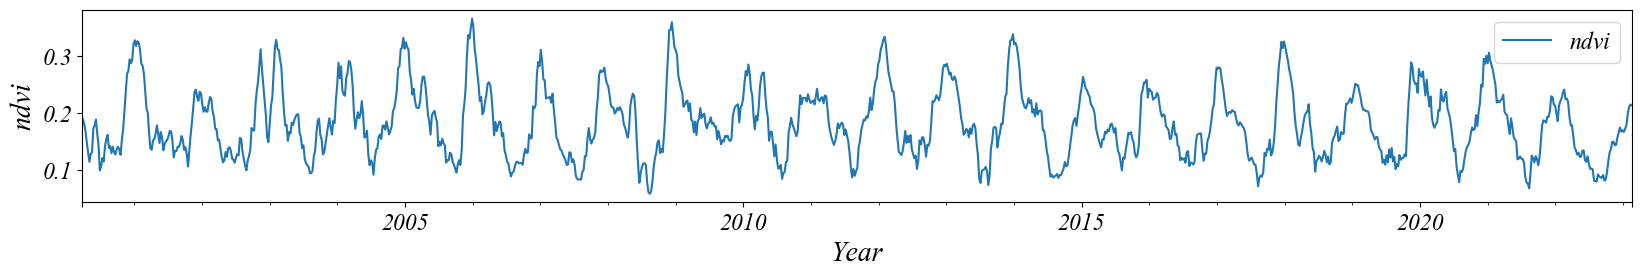

In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
# Plot
# ==============================================================================
font1 = {'family':'Times New Roman','color':'blue','size':20}
font2 = {'family':'Times New Roman','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data['ndvi'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

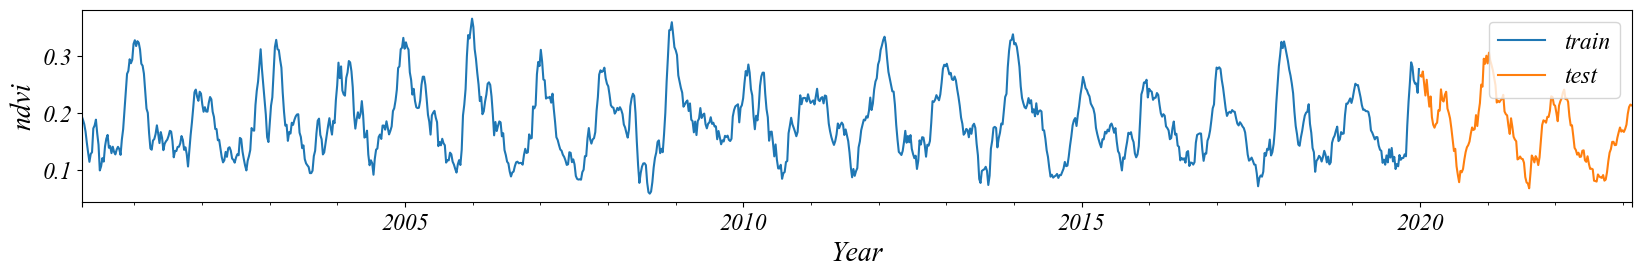

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndvi'].plot(ax=ax, label='train')
data_test['ndvi'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

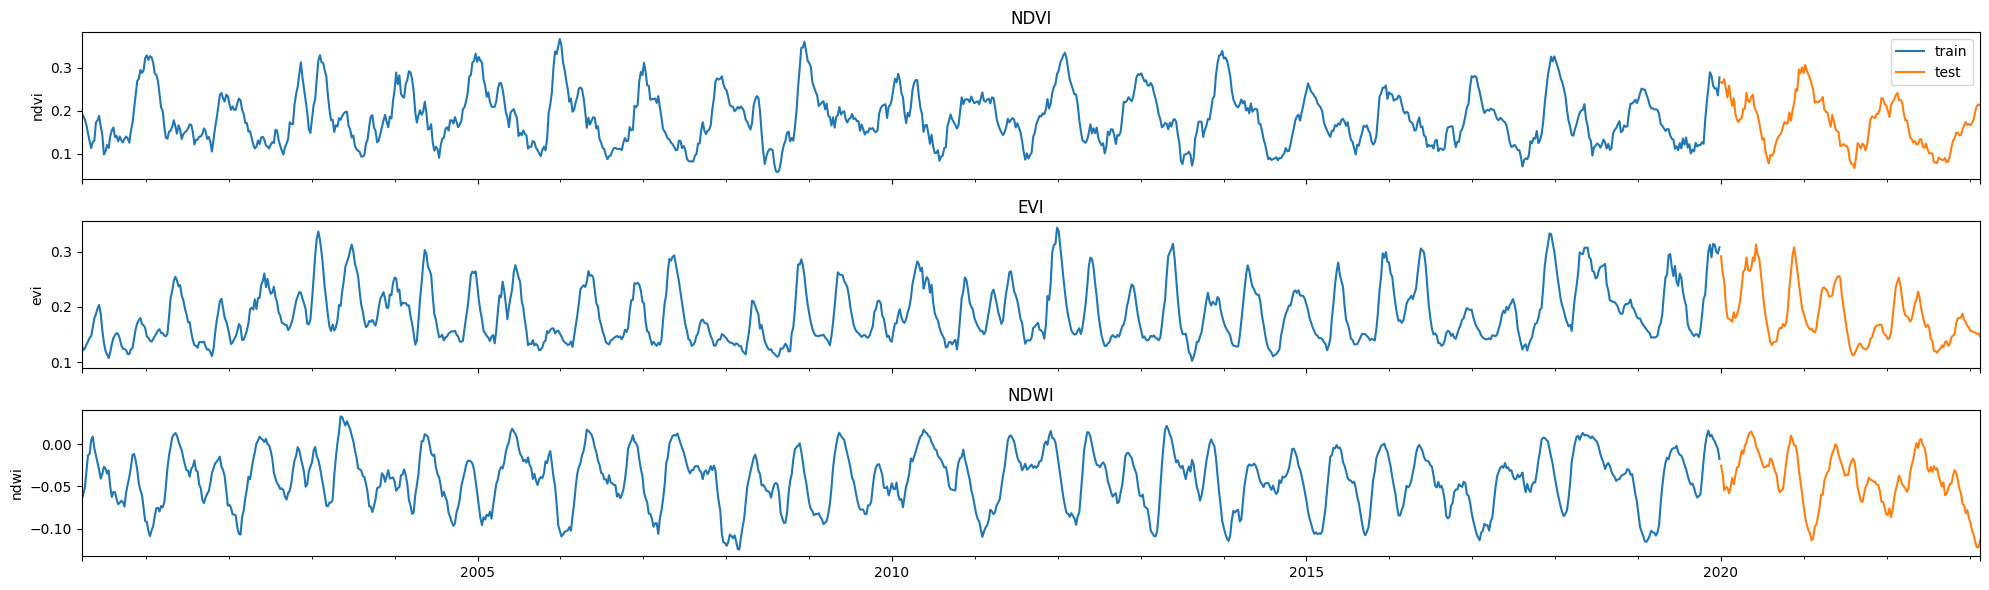

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 6), sharex=True)

data_train['ndvi'].plot(label='train', ax=axes[0])
data_test['ndvi'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('ndvi')
axes[0].set_title('NDVI')
axes[0].legend()

data_train['evi'].plot(label='train', ax=axes[1])
data_test['evi'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('evi')
axes[1].set_title('EVI')

data_train['ndwi'].plot(label='train', ax=axes[2])
data_test['ndwi'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('ndwi')
axes[2].set_title('NDWI')

fig.tight_layout()
plt.show();

### parallel Multivariate Vanilla LSTM 100-lag

> **Multiple Parallel Series** is an alternate time series problem where there are multiple parallel time series and a value must be predicted for each.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
#Scaling the dataset
from sklearn.preprocessing import MinMaxScaler
scaler=StandardScaler()
train_data=scaler.fit_transform(np.array(data_train))
test_data=scaler.fit_transform(np.array(data_test))
#print(df_train)

In [ ]:
train_data[:,0]

array([ 0.17816959,  0.07293534, -0.0569548 , ...,  1.12595899,
        0.85467078,  1.54456384])

In [ ]:
# data must be split into input/output samples in order to train a model
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    end_ix = i + n_steps
    if end_ix > len(sequences)-1:
      break
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
# multivariate data preparation
from numpy import array
from numpy import hstack

in_seq1 = np.array(train_data[:,0])
in_seq2 = np.array(train_data[:,1])
out_seq = np.array(train_data[:,2])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
train_dataset = hstack((in_seq1, in_seq2, out_seq))

In [ ]:
train_dataset

array([[ 0.17816959, -1.09966888, -0.7220306 ],
       [ 0.07293534, -1.29846099, -0.5172568 ],
       [-0.0569548 , -1.2392817 , -0.29977908],
       ...,
       [ 1.12595899,  2.20720781,  1.2122062 ],
       [ 0.85467078,  2.1474649 ,  1.07294387],
       [ 1.54456384,  2.36763705,  0.72744753]])

In [ ]:
in_seq1 = np.array(test_data[:,0])
in_seq2 = np.array(test_data[:,1])
out_seq = np.array(test_data[:,2])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
test_dataset = hstack((in_seq1, in_seq2, out_seq))

In [ ]:
lags = 100
# convert into input/output
X_train, y_train = split_sequences(train_dataset, lags)
X_test, y_test = split_sequences(test_dataset, lags)

In [ ]:
print(X_train.shape), print(y_train.shape)

(932, 100, 3)
(932, 3)


(None, None)

In [ ]:
print(X_test.shape), print(y_test.shape)

(64, 100, 3)
(64, 3)


(None, None)

In [ ]:
#X_test=X_test.reshape(-1,1)

In [ ]:
X_train.shape

(932, 100, 3)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
# define model
def LSTM_model():
  model = Sequential()
  model.add(LSTM(100, activation='relu', input_shape=(lags, y_train.shape[1])))
  model.add(Dropout(0.01))
  model.add(Dense(y_train.shape[1]))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
# define the grid search parameters
batchSize = [10,20, 50,100,200]
epochs = [20,50,100]

In [ ]:
# create model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
model = KerasRegressor(build_fn=LSTM_model)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
parameter_grid = dict(batch_size=batchSize, epochs=epochs)

In [ ]:
grid = HalvingGridSearchCV(estimator=model, param_grid=parameter_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/100
21/21 [==============================] - 3s 25ms/step - loss: 0.8060
Epoch 2/100
21/21 [==============================] - 1s 25ms/step - loss: 0.4104
Epoch 3/100
21/21 [==============================] - 1s 25ms/step - loss: 0.2199
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.1582
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.1219
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 0.1099
Epoch 7/100
21/21 [==============================] - 0s 16ms/step - loss: 0.1027
Epoch 8/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0875
Epoch 9/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0829
Epoch 10/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0809
Epoch 11/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0768
Epoch 12/100
21/21 [==============================] - 0s 15ms/step - loss: 0.0689
Epoch 13/100
21/21 [=====

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.062325 using {'batch_size': 50, 'epochs': 100}
-0.146542 (0.018619) with: {'batch_size': 10, 'epochs': 20}
-0.086614 (0.009668) with: {'batch_size': 10, 'epochs': 50}
-0.089283 (0.018403) with: {'batch_size': 10, 'epochs': 100}
-0.187091 (0.052279) with: {'batch_size': 20, 'epochs': 20}
-0.096043 (0.009635) with: {'batch_size': 20, 'epochs': 50}
-0.086854 (0.013048) with: {'batch_size': 20, 'epochs': 100}
-0.293839 (0.021694) with: {'batch_size': 50, 'epochs': 20}
-0.120802 (0.011313) with: {'batch_size': 50, 'epochs': 50}
-0.084241 (0.011890) with: {'batch_size': 50, 'epochs': 100}
-0.503928 (0.043413) with: {'batch_size': 100, 'epochs': 20}
-0.179331 (0.013593) with: {'batch_size': 100, 'epochs': 50}
-0.100179 (0.010234) with: {'batch_size': 100, 'epochs': 100}
-0.588161 (0.070080) with: {'batch_size': 200, 'epochs': 20}
-0.188405 (0.043493) with: {'batch_size': 200, 'epochs': 50}
-0.105849 (0.016632) with: {'batch_size': 200, 'epochs': 100}
-0.063984 (0.003779) with: {'batc

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
# define model
def LSTM_model(neurons, dropout_rate,optimizer):
  model = Sequential()
  model.add(LSTM(neurons, activation='relu', input_shape=(lags, y_train.shape[1])))
  model.add(Dropout(dropout_rate))
  model.add(Dense( y_train.shape[1]))
  model.compile(loss='mae', optimizer=optimizer)
  return model

In [ ]:
# create model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
model = KerasRegressor(build_fn=LSTM_model, epochs=100, batch_size=50)
# define the grid search parameters
neurons = [30, 50, 100,128,150]
optimizer = ['SGD', 'RMSprop', 'Adam']
dropout_rate = [0.01,0.1,0.15,0.2,0.25,0.3]

param_grid = dict(neurons=neurons,dropout_rate=dropout_rate,optimizer=optimizer)
grid = HalvingGridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/100
21/21 [==============================] - 2s 21ms/step - loss: 0.5946
Epoch 2/100
21/21 [==============================] - 0s 21ms/step - loss: 0.4087
Epoch 3/100
21/21 [==============================] - 0s 21ms/step - loss: 0.3433
Epoch 4/100
21/21 [==============================] - 0s 21ms/step - loss: 0.3186
Epoch 5/100
21/21 [==============================] - 0s 21ms/step - loss: 0.3006
Epoch 6/100
21/21 [==============================] - 0s 21ms/step - loss: 0.2812
Epoch 7/100
21/21 [==============================] - 0s 22ms/step - loss: 0.2756
Epoch 8/100
21/21 [==============================] - 0s 20ms/step - loss: 0.2629
Epoch 9/100
21/21 [==============================] - 0s 21ms/step - loss: 0.2548
Epoch 10/100
21/21 [==============================] - 0s 22ms/step - loss: 0.2441
Epoch 11/100
21/21 [==============================] - 0s 21ms/step - loss: 0.2368
Epoch 12/100
21/21 [==============================] - 0s 22ms/step - loss: 0.2265
Epoch 13/100
21/21 [=====

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.180938 using {'dropout_rate': 0.1, 'neurons': 150, 'optimizer': 'RMSprop'}
-0.679060 (0.104284) with: {'dropout_rate': 0.01, 'neurons': 30, 'optimizer': 'SGD'}
-0.815015 (0.142955) with: {'dropout_rate': 0.01, 'neurons': 30, 'optimizer': 'RMSprop'}
-1.336643 (0.926651) with: {'dropout_rate': 0.01, 'neurons': 30, 'optimizer': 'Adam'}
-0.666235 (0.115207) with: {'dropout_rate': 0.01, 'neurons': 50, 'optimizer': 'SGD'}
-0.597875 (0.041529) with: {'dropout_rate': 0.01, 'neurons': 50, 'optimizer': 'RMSprop'}
-0.578532 (0.083450) with: {'dropout_rate': 0.01, 'neurons': 50, 'optimizer': 'Adam'}
-0.635738 (0.103786) with: {'dropout_rate': 0.01, 'neurons': 100, 'optimizer': 'SGD'}
-0.644837 (0.171319) with: {'dropout_rate': 0.01, 'neurons': 100, 'optimizer': 'RMSprop'}
-1.172076 (0.717100) with: {'dropout_rate': 0.01, 'neurons': 100, 'optimizer': 'Adam'}
-0.639197 (0.091446) with: {'dropout_rate': 0.01, 'neurons': 128, 'optimizer': 'SGD'}
-0.550803 (0.014533) with: {'dropout_rate': 0.0

In [ ]:
n_features = X_train.shape[2]
...
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(lags, y_train.shape[1])))
model.add(Dropout(0.1))
model.add(Dense( y_train.shape[1]))
model.compile(loss='mae', optimizer='RMSprop')


In [ ]:
# fit model
history=model.fit(X_train, y_train, epochs=100, batch_size=50,validation_split=0.1, verbose=1,shuffle=False)

Epoch 1/100
19/19 [==============================] - 4s 70ms/step - loss: 0.6868 - val_loss: 0.5263
Epoch 2/100
19/19 [==============================] - 1s 42ms/step - loss: 0.4819 - val_loss: 0.4569
Epoch 3/100
19/19 [==============================] - 1s 47ms/step - loss: 0.4155 - val_loss: 0.3937
Epoch 4/100
19/19 [==============================] - 1s 39ms/step - loss: 0.3749 - val_loss: 0.3648
Epoch 5/100
19/19 [==============================] - 1s 44ms/step - loss: 0.3546 - val_loss: 0.3741
Epoch 6/100
19/19 [==============================] - 1s 46ms/step - loss: 0.3415 - val_loss: 0.3150
Epoch 7/100
19/19 [==============================] - 1s 42ms/step - loss: 0.3184 - val_loss: 0.3077
Epoch 8/100
19/19 [==============================] - 1s 47ms/step - loss: 0.3086 - val_loss: 0.2618
Epoch 9/100
19/19 [==============================] - 1s 53ms/step - loss: 0.2922 - val_loss: 0.2790
Epoch 10/100
19/19 [==============================] - 1s 59ms/step - loss: 0.2825 - val_loss: 0.2509

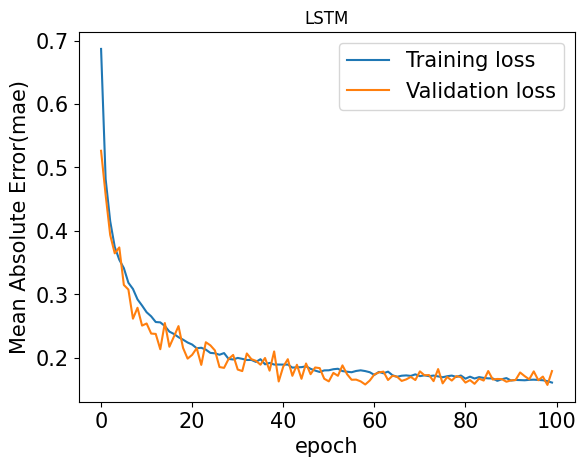

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('LSTM')
plt.xlabel('epoch', fontsize=15)
plt.ylabel('Mean Absolute Error(mae)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

In [ ]:
#train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

5/5 [==============================] - 1s 11ms/step


In [ ]:
#train_predict=scaler.inverse_transform(train_predict)
y_pred_future=scaler.inverse_transform(test_predict)

In [ ]:
y_pred_future=pd.DataFrame(y_pred_future)

In [ ]:
y_pred_future.shape

(154, 3)

In [ ]:
y_pred_future

,0,1,2
0,0.193680,0.190743,-0.034755
1,0.171896,0.198856,-0.020603
2,0.169159,0.206173,-0.018120
3,0.180235,0.224856,-0.011318
4,0.189107,0.257782,-0.002043
...,...,...,...
149,0.173700,0.150046,-0.100716
150,0.179870,0.148474,-0.102191
151,0.194655,0.146612,-0.108983
152,0.204208,0.143003,-0.113512


In [ ]:
datap = data_test[-len(y_pred_future):]
datap

,ndvi,evi,ndwi
date,,,
2020-03-12,0.179186,0.185412,-0.027670
2020-03-19,0.173929,0.196222,-0.026516
2020-03-26,0.180050,0.210708,-0.017573
2020-04-02,0.182786,0.236451,-0.007602
2020-04-09,0.204729,0.263871,-0.011516
...,...,...,...
2023-01-19,0.179294,0.154222,-0.106630
2023-01-26,0.198209,0.153708,-0.115402
2023-02-02,0.210345,0.151326,-0.121956


In [ ]:
y_pred_future['date']=datap.index
y_pred_future=y_pred_future.set_index('date')

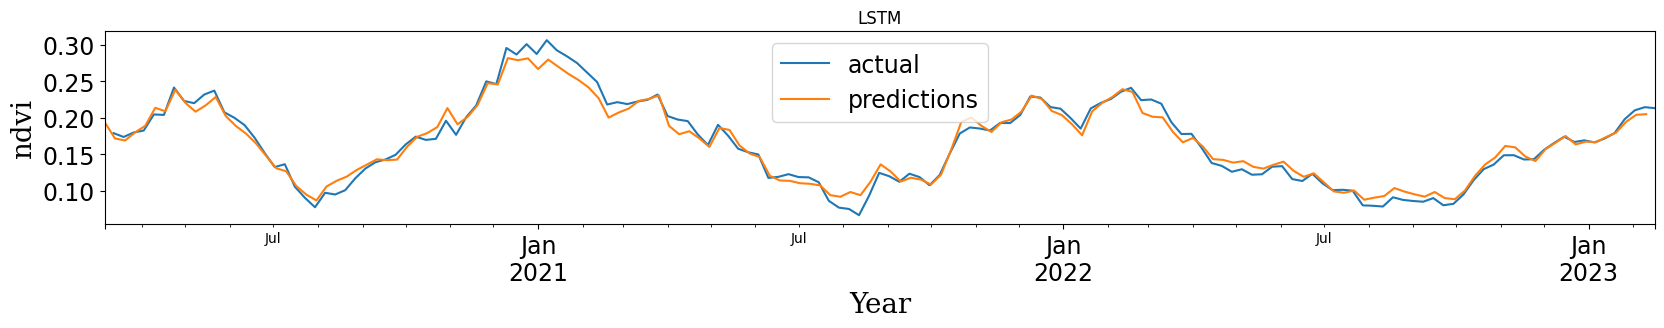

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.ndvi.plot(ax=ax, label='actual',title='LSTM')
y_pred_future[0].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

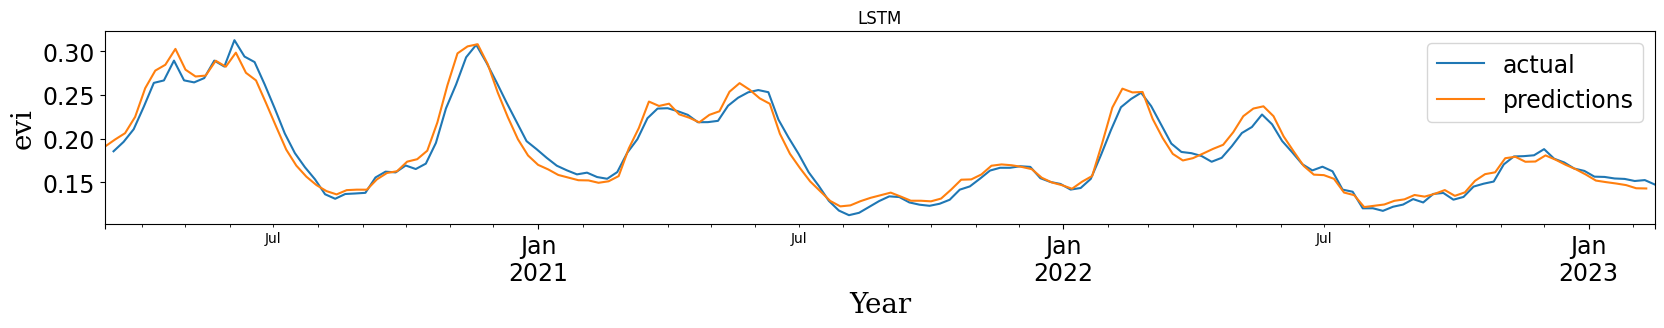

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.evi.plot(ax=ax, label='actual',title='LSTM')
y_pred_future[1].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("evi",fontdict = font2)
ax.legend(fontsize=17);

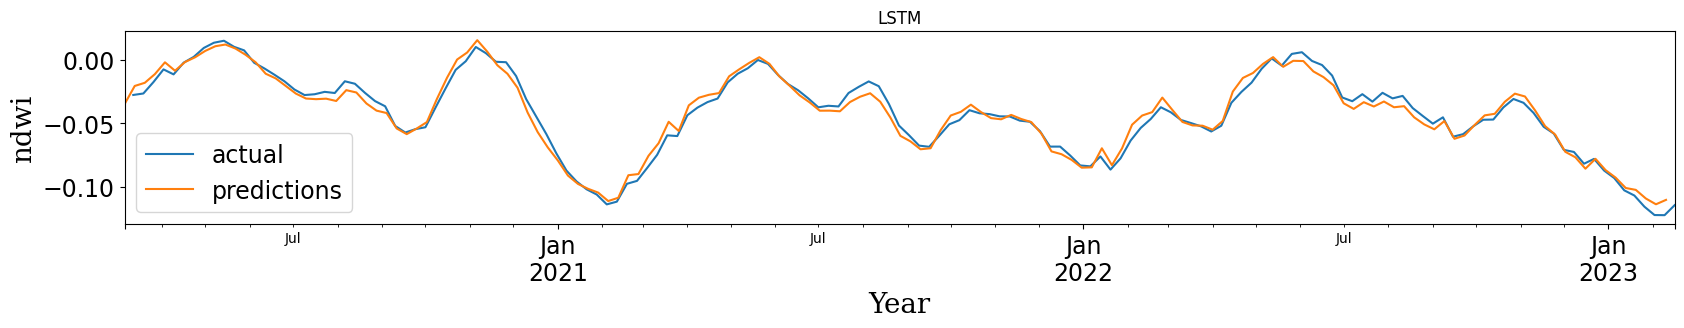

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.ndwi.plot(ax=ax, label='actual',title='LSTM')
y_pred_future[2].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndwi",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(datap.ndvi,y_pred_future[0])
mse = mean_squared_error(datap.ndvi,y_pred_future[0])
r2 = r2_score(datap.ndvi,y_pred_future[0])
rmse = math.sqrt(mean_squared_error(datap.ndvi,y_pred_future[0]))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 0.011718833814484336
MSE is 0.00021556243445187992
R2 is 0.9316239327710968
RMSE is 0.014682044627771703


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(datap.ndwi,y_pred_future[2])
mse = mean_squared_error(datap.ndwi,y_pred_future[2])
r2 = r2_score(datap.ndwi,y_pred_future[2])
rmse = math.sqrt(mean_squared_error(datap.ndwi,y_pred_future[2]))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 0.005386539620284913
MSE is 4.358477172030147e-05
R2 is 0.9566738553914365
RMSE is 0.006601876378750322


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(y_test,test_predict)
mse = mean_squared_error(y_test,test_predict)
r2 = r2_score(y_test,test_predict)
rmse = math.sqrt(mean_squared_error(y_test,test_predict))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 0.1743826680178783
MSE is 0.049348827016046336
R2 is 0.95048308671022
RMSE is 0.2221459588109726


In [ ]:
X_test.shape

(64, 100, 3)

In [ ]:
#Taking the last 500 values as input to predic future values
x_input=X_test[-1:]
x_input.shape

(1, 100, 3)

In [ ]:
#x_input

In [ ]:
temp_input=x_input
temp_input=temp_input[0].tolist()

In [ ]:
ip=np.array(temp_input)

In [ ]:
#from numpy import zeros, newaxis
#b = yhat[newaxis,:, :]
#b.shape

In [ ]:
#temp_input.extend(b)
#temp_input

In [ ]:
# demonstrate prediction for next 5 year
from numpy import array
from numpy import zeros, newaxis

lst_output=[]
#n_steps=100
i=1
while(i<=300):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} input: \n\n{}".format(i,x_input))
        x_input = x_input.reshape((1, n_steps, 3))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("\n{} th output: {}\n\n\n".format(i,yhat))
        yhat = yhat[newaxis,:, :]
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        #x_input = x_input.reshape((1, n_steps,3))
        yhat = model.predict(x_input, verbose=0)
        yhat = yhat[newaxis,:, :]
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


Streaming output truncated to the last 5000 lines.
 [-1.08497071 -0.95458055 -0.03485718]
 [-1.09010875 -0.9911477  -0.15631658]
 [-1.080217   -0.99811012 -0.25934798]
 [-1.05933201 -0.98360634 -0.33901292]
 [-1.03221858 -0.95432657 -0.38698027]
 [-1.00495017 -0.9164114  -0.39788285]
 [-0.98316199 -0.8725611  -0.36711916]
 [-0.96923637 -0.82155502 -0.29459736]
 [-0.9616887  -0.75545466 -0.18236722]
 [-0.94630748 -0.66101128 -0.02746445]
 [-0.89518273 -0.52404523  0.1654112 ]
 [-0.78113401 -0.3346343   0.37742984]
 [-0.59636253 -0.10033531  0.58470005]
 [-0.34304261  0.16783816  0.76265407]
 [-0.03569951  0.45458668  0.89988953]
 [ 0.29313195  0.74485499  0.99225515]
 [ 0.60159117  1.01782942  1.03586376]
 [ 0.86243623  1.26262248  1.03945935]
 [ 1.05766606  1.47450936  1.01831877]
 [ 1.17631698  1.64764071  0.98623443]
 [ 1.22609448  1.77999139  0.95543963]
 [ 1.23042798  1.88019824  0.93356818]
 [ 1.21299732  1.96050191  0.9199515 ]
 [ 1.18833995  2.02711582  0.91197604]
 [ 1.16068637

In [ ]:
print(lst_output)

[[[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.8894312977790833, -2.200204849243164]], [[0.582460343837738, -0.889431297779083

In [ ]:
len(lst_output)

300

In [ ]:
prediction=np.array(lst_output)

In [ ]:
train_date=pd.to_datetime(data.index)
train_date

DatetimeIndex(['2000-03-23', '2000-03-30', '2000-04-06', '2000-04-13',
               '2000-04-20', '2000-04-27', '2000-05-04', '2000-05-11',
               '2000-05-18', '2000-05-25',
               ...
               '2022-12-15', '2022-12-22', '2022-12-29', '2023-01-05',
               '2023-01-12', '2023-01-19', '2023-01-26', '2023-02-02',
               '2023-02-09', '2023-02-16'],
              dtype='datetime64[ns]', name='date', length=1196, freq='7D')

In [ ]:
n_week_for_prediction=300  #let us predict 1 year

predict_period_dates = pd.date_range(list(train_date)[-1], periods=n_week_for_prediction, freq='7D').tolist()
print(predict_period_dates)


[Timestamp('2023-02-16 00:00:00', freq='7D'), Timestamp('2023-02-23 00:00:00', freq='7D'), Timestamp('2023-03-02 00:00:00', freq='7D'), Timestamp('2023-03-09 00:00:00', freq='7D'), Timestamp('2023-03-16 00:00:00', freq='7D'), Timestamp('2023-03-23 00:00:00', freq='7D'), Timestamp('2023-03-30 00:00:00', freq='7D'), Timestamp('2023-04-06 00:00:00', freq='7D'), Timestamp('2023-04-13 00:00:00', freq='7D'), Timestamp('2023-04-20 00:00:00', freq='7D'), Timestamp('2023-04-27 00:00:00', freq='7D'), Timestamp('2023-05-04 00:00:00', freq='7D'), Timestamp('2023-05-11 00:00:00', freq='7D'), Timestamp('2023-05-18 00:00:00', freq='7D'), Timestamp('2023-05-25 00:00:00', freq='7D'), Timestamp('2023-06-01 00:00:00', freq='7D'), Timestamp('2023-06-08 00:00:00', freq='7D'), Timestamp('2023-06-15 00:00:00', freq='7D'), Timestamp('2023-06-22 00:00:00', freq='7D'), Timestamp('2023-06-29 00:00:00', freq='7D'), Timestamp('2023-07-06 00:00:00', freq='7D'), Timestamp('2023-07-13 00:00:00', freq='7D'), Timestamp

In [ ]:
predict_period_dates = pd.to_datetime(predict_period_dates)

In [ ]:
predict_period_dates

DatetimeIndex(['2023-02-16', '2023-02-23', '2023-03-02', '2023-03-09',
               '2023-03-16', '2023-03-23', '2023-03-30', '2023-04-06',
               '2023-04-13', '2023-04-20',
               ...
               '2028-09-07', '2028-09-14', '2028-09-21', '2028-09-28',
               '2028-10-05', '2028-10-12', '2028-10-19', '2028-10-26',
               '2028-11-02', '2028-11-09'],
              dtype='datetime64[ns]', length=300, freq=None)

In [ ]:
y_pred_future=prediction

In [ ]:
y_pred_future

array([[[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.8894313 , -2.20020485]],

       [[ 0.58246034, -0.889431

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [ ]:
y_pred_future=np.array(y_pred_future)
y_pred_future = y_pred_future.reshape(len(y_pred_future),3)

In [ ]:
y_pred_future = scaler.inverse_transform(y_pred_future)

In [ ]:
df_forecast = pd.DataFrame(y_pred_future, columns = ['ndvi_pred','evi_pred','ndwi_pred'])
df_forecast

,ndvi_pred,evi_pred,ndwi_pred
0,0.205088,0.142757,-0.110053
1,0.205088,0.142757,-0.110053
2,0.205088,0.142757,-0.110053
3,0.205088,0.142757,-0.110053
4,0.205088,0.142757,-0.110053
...,...,...,...
295,0.237382,0.269625,-0.020095
296,0.238062,0.271209,-0.021044
297,0.239247,0.272629,-0.021939
298,0.240512,0.273735,-0.022760


In [ ]:
df_forcdate = pd.DataFrame({'Date':np.array(forecast_dates).flatten()})
df_forcdate

,Date
0,2023-02-16
1,2023-02-23
2,2023-03-02
3,2023-03-09
4,2023-03-16
...,...
295,2028-10-12
296,2028-10-19
297,2028-10-26
298,2028-11-02


In [ ]:
df_forecast['Date'] = df_forcdate['Date']
df_forecast=df_forecast.set_index('Date')
df_forecast.head()

,ndvi_pred,evi_pred,ndwi_pred
Date,,,
2023-02-16,0.205088,0.142757,-0.110053
2023-02-23,0.205088,0.142757,-0.110053
2023-03-02,0.205088,0.142757,-0.110053
2023-03-09,0.205088,0.142757,-0.110053
2023-03-16,0.205088,0.142757,-0.110053


Text(0, 0.5, 'NDVI')

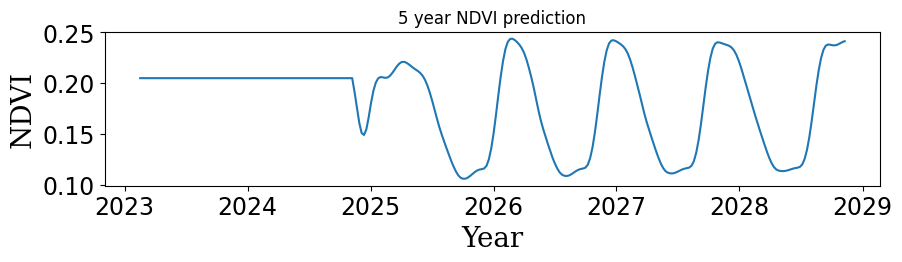

In [ ]:

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['ndvi_pred'].plot(ax=ax, label='ndvi',title='5 year NDVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDVI",fontdict = font2)

Text(0, 0.5, 'EVI')

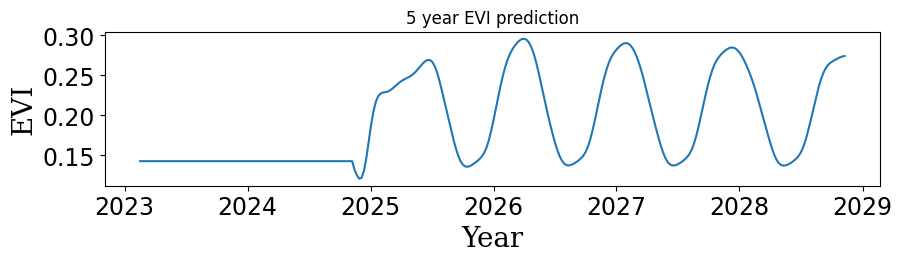

In [ ]:
#df_forecast['SPI_pred'].plot(figsize=(10, 2))

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['evi_pred'].plot(ax=ax, label='ndvi',title='5 year EVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("EVI",fontdict = font2)

Text(0, 0.5, 'NDWI')

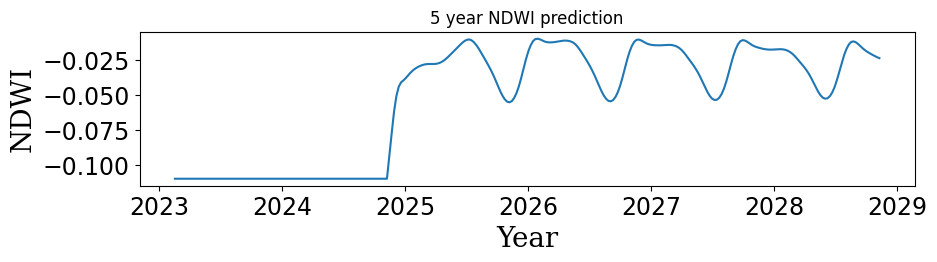

In [ ]:

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['ndwi_pred'].plot(ax=ax, label='ndvi',title='5 year NDWI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDWI",fontdict = font2)